# TIME SERIES FORECASTING OF NATURAL GAS PRICES

**Author:** [Igemhokhai Shedrach](https://www.linkedin.com/igemhokhai-shedrach-60982819a)

Time series forecasting is a technique for the prediction of events through a sequence of time. The technique is used across many fields of study, from the geology to behavior to economics. The techniques predict future events by analyzing the trends of the past, on the assumption that future trends will hold similar to historical trends.

**Goals of this Project :**
#### Used Machine Learning to Build a time series forecasting model of Natural Gas Prices using Two Models :
- AutoReg
- ARIMA

**Source of Data :**
For this project, data from [The U.S Energy Information Administration]("www.eia.gov") was used, The Website "www.eia.gov" contains the price of Natural gas from 1994 till date(imputed daily)

##### importing Libraries

In [81]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings(action="ignore")

##### Load dataset into pandas DataFrame

In [3]:
df=pd.read_csv(r"C:\Users\User\Desktop\Machine Learning Project\Time Series\Natural_Gas_Futures_Contract_1.csv",
              skiprows=range(4))
df.head()

Day  Natural Gas Futures Contract 1  Dollars per Million Btu
0  08/16/2022                                              9.329      
1  08/15/2022                                              8.728      
2  08/12/2022                                              8.768      
3  08/11/2022                                              8.874      
4  08/10/2022                                              8.202

##### Analysis and Wrangling of Data

In [4]:
df.columns

Index(['Day', 'Natural Gas Futures Contract 1  Dollars per Million Btu'], dtype='object')

In [5]:
df["gas_price"]=df['Natural Gas Futures Contract 1  Dollars per Million Btu']
df.drop(columns='Natural Gas Futures Contract 1  Dollars per Million Btu', inplace=True)
df.head()

Day  gas_price
0  08/16/2022      9.329
1  08/15/2022      8.728
2  08/12/2022      8.768
3  08/11/2022      8.874
4  08/10/2022      8.202

In [6]:
print("shape :",df.shape)
df.info()

shape : (7181, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7181 entries, 0 to 7180
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Day        7181 non-null   object 
 1   gas_price  7181 non-null   float64
dtypes: float64(1), object(1)
memory usage: 112.3+ KB


Convert the "Day" column to a Datetime format, since we are dealing with time series

In [7]:
df["Day"]=pd.to_datetime(df["Day"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7181 entries, 0 to 7180
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Day        7181 non-null   datetime64[ns]
 1   gas_price  7181 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 112.3 KB


As seen in the data frame above, the order of the Date column was from recent date to old date. we would now reorder it to start from oldest to recent date.

In [8]:
df1=df.reindex(index=df.index[::-1])
df1=df1.set_index("Day")
df1.head(20)

gas_price
Day                  
1994-01-13      2.194
1994-01-14      2.268
1994-01-17      2.360
1994-01-18      2.318
1994-01-19      2.252
1994-01-20      2.250
1994-01-21      2.305
1994-01-24      2.470
1994-01-25      2.246
1994-01-26      2.359
1994-01-27      2.417
1994-01-28      2.528
1994-01-31      2.554
1994-02-01      2.639
1994-02-02      2.585
1994-02-03      2.383
1994-02-04      2.369
1994-02-07      2.347
1994-02-08      2.411
1994-02-09      2.358

In [9]:
df1.describe()

gas_price
count  7181.000000
mean      4.035220
std       2.211276
min       1.323000
25%       2.467000
50%       3.316000
75%       4.981000
max      15.378000

Our data is missing some days and since Time Series Forecasting Requires a data with a constant frequency, we would now convert the frequency of the data to a daily frequency.

In [10]:
df1=df1.asfreq(pd.infer_freq(df1.index))

In [11]:
df1

gas_price
Day                  
1994-01-13      2.194
1994-01-14      2.268
1994-01-15        NaN
1994-01-16        NaN
1994-01-17      2.360
...               ...
2022-08-12      8.768
2022-08-13        NaN
2022-08-14        NaN
2022-08-15      8.728
2022-08-16      9.329

[10443 rows x 1 columns]

The Setting of the frequency of our data to daily resulted in rows with NaNs. we would fill those rows using a forward fill technique i.e data from the previous row is imputed in the next row with missing values.

In [12]:
df1["gas_price"]=df1["gas_price"].ffill()

In [13]:
df1.head()

gas_price
Day                  
1994-01-13      2.194
1994-01-14      2.268
1994-01-15      2.268
1994-01-16      2.268
1994-01-17      2.360

Are there missing values in our data?

In [14]:
df1["gas_price"].isnull().sum()

0

- Our data has no missing values.

Next, lets see how the values in our data is distributed.

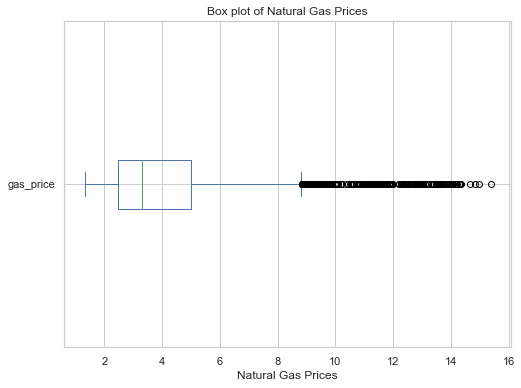

In [15]:
df1.plot(kind='box',vert=False, figsize=(8, 6))
plt.title('Box plot of Natural Gas Prices')
plt.xlabel('Natural Gas Prices')
plt.show()

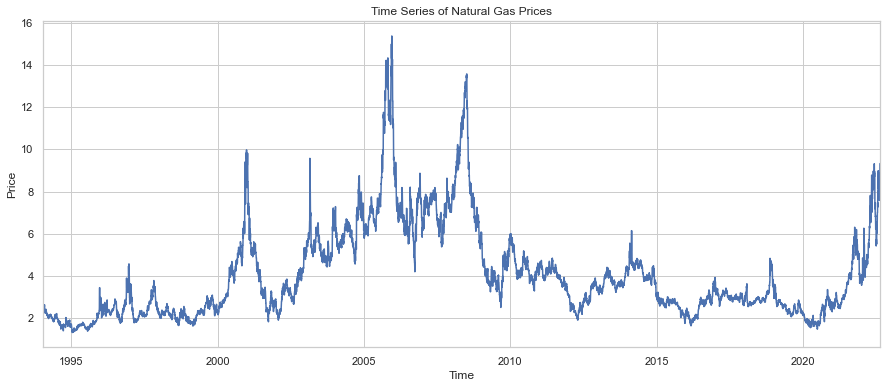

In [16]:
fig,ax=plt.subplots(figsize=(15,6))
df1["gas_price"].plot(ax=ax, xlabel="Time",ylabel="Price",title="Time Series of Natural Gas Prices");

##### Lets see if our data Contains Trends and Seasonality, usimg Statsmodel's seasonal_decompose

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose

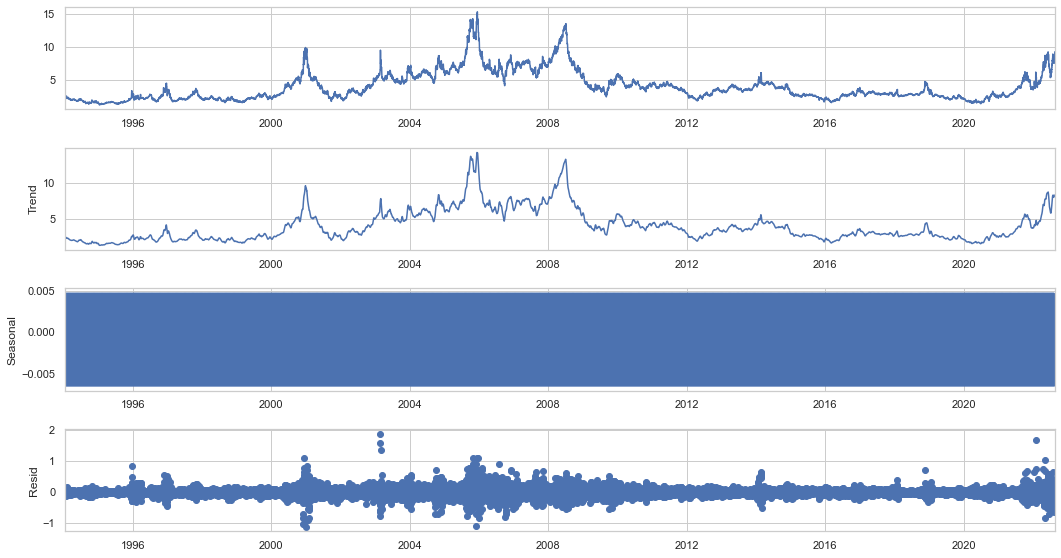

In [18]:
plt.rc("figure",figsize=(15,8))
plt.rc("font", size=15)
result=seasonal_decompose(df1,model="additive", period=12)
fig=result.plot()

##### We would now create an ACF and PACF plot to see how well the present values of our Series is Related with its past values

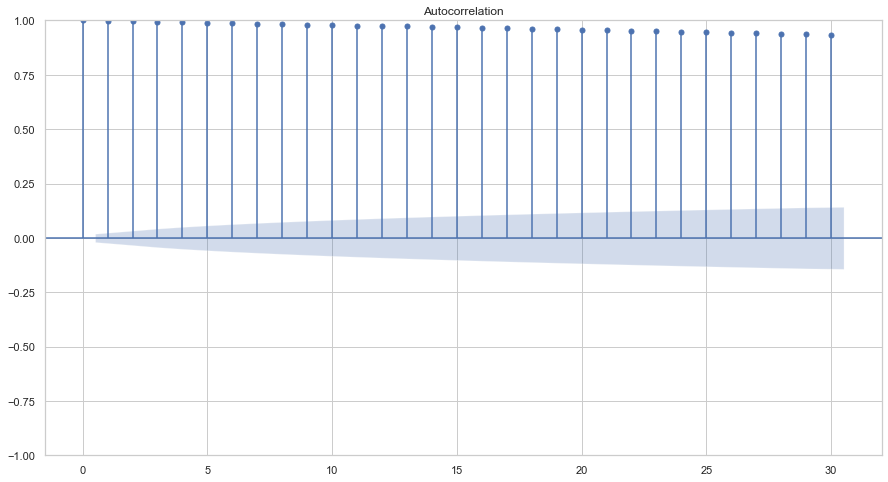

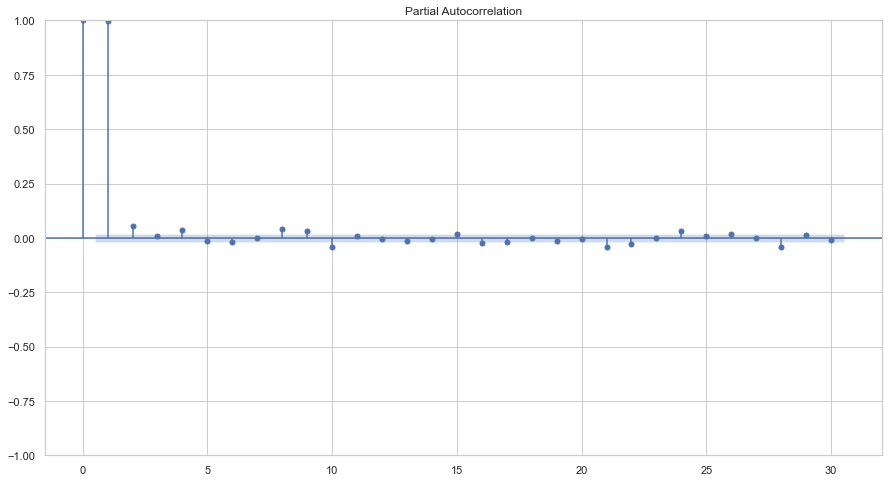

In [19]:
fig1=plot_acf(df1,lags=30)
fig2=plot_pacf(df1, lags=30)
fig1.show()

We can see from the ACF plot, that The previous data(up to 30 days) has some strong correlation with the present Value, while the PACF plot(Which is a more important factor) shows that the previous two lags have the strongest correlation.

###### Splitting of data into train and test set.

In [20]:
cutoff=int(len(df1["gas_price"])*0.9)
train=df1["gas_price"].iloc[:cutoff]
test=df1["gas_price"].iloc[cutoff:]
print("Shape of Training Data :", train.shape)
print("Shape of Test Data :", test.shape)

Shape of Training Data : (9398,)
Shape of Test Data : (1045,)


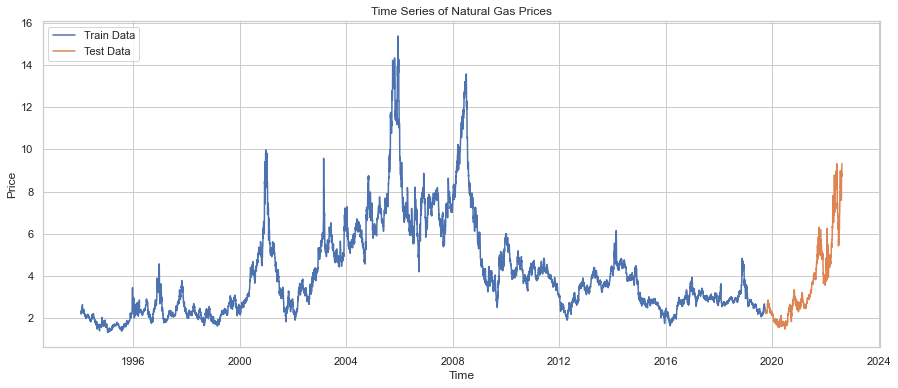

In [21]:
plt.figure(figsize=(15,6))
plt.plot(train)
plt.plot(test)
plt.title("Time Series of Natural Gas Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(["Train Data", "Test Data"],loc="upper left");

##### Lets create a baseline for our model. A good Performing model must beat the baseline.

In [22]:
train_mean=train.mean()
train_pred_baseline=[train_mean]*len(train)
train_mae=mean_absolute_error(train,train_pred_baseline)
print("Mean Natural Gas Prices: ", train_mean)
print("Baseline MAE:", train_mae)

Mean Natural Gas Prices:  4.083821344966994
Baseline MAE: 1.7014121028453835


# AUTOREG

##### Hyperparameter tuning to determine the optimum number of lags to used for the model building

In [23]:
p_params=range(1,31)
maes=list()
for p in p_params:
    start_time=time.time()
    model=AutoReg(train, lags=p).fit()
    end_time=round(time.time()-start_time,2)
    print(f" Trained Model {p} in {end_time} seconds")
    pred=model.predict().dropna()
    mae=mean_absolute_error(train.iloc[p:],pred)
    maes.append(mae)
    
    pass
mae_series=pd.Series(maes, name="mae", index=p_params)
mae_series.head()

 Trained Model 1 in 0.01 seconds
 Trained Model 2 in 0.02 seconds
 Trained Model 3 in 0.0 seconds
 Trained Model 4 in 0.0 seconds
 Trained Model 5 in 0.0 seconds
 Trained Model 6 in 0.02 seconds
 Trained Model 7 in 0.0 seconds
 Trained Model 8 in 0.02 seconds
 Trained Model 9 in 0.0 seconds
 Trained Model 10 in 0.0 seconds
 Trained Model 11 in 0.02 seconds
 Trained Model 12 in 0.02 seconds
 Trained Model 13 in 0.0 seconds
 Trained Model 14 in 0.02 seconds
 Trained Model 15 in 0.02 seconds
 Trained Model 16 in 0.02 seconds
 Trained Model 17 in 0.02 seconds
 Trained Model 18 in 0.02 seconds
 Trained Model 19 in 0.02 seconds
 Trained Model 20 in 0.02 seconds
 Trained Model 21 in 0.02 seconds
 Trained Model 22 in 0.02 seconds
 Trained Model 23 in 0.02 seconds
 Trained Model 24 in 0.02 seconds
 Trained Model 25 in 0.02 seconds
 Trained Model 26 in 0.02 seconds
 Trained Model 27 in 0.03 seconds
 Trained Model 28 in 0.02 seconds
 Trained Model 29 in 0.02 seconds
 Trained Model 30 in 0.03 seco

1    0.072538
2    0.072532
3    0.072553
4    0.073289
5    0.073430
Name: mae, dtype: float64

In [24]:
mae_series

1     0.072538
2     0.072532
3     0.072553
4     0.073289
5     0.073430
6     0.073562
7     0.073568
8     0.073532
9     0.073532
10    0.073744
11    0.073766
12    0.073785
13    0.073776
14    0.073807
15    0.073809
16    0.073833
17    0.073882
18    0.073886
19    0.073989
20    0.073995
21    0.074143
22    0.074150
23    0.074164
24    0.074211
25    0.074231
26    0.074359
27    0.074421
28    0.074593
29    0.074601
30    0.074641
Name: mae, dtype: float64

In [25]:
mae_series.min()

0.0725323597314582

In [163]:
best_p=mae_series[mae_series==mae_series.min()].index[0]
print("Optimum number of lags :", best_p)
best_model=AutoReg(train, lags=best_p).fit()

Optimum number of lags : 2


As seen above, the optimum number of lags to be used is 2, as it has the least mean absolute error

#### Save Model

In [164]:
import pickle
with open("AUTOREG-Model(Gas)", "wb") as f :
    pickle.dump(model, f)
print("Model Saved")

Model Saved


##### Next, lets see the Residuals of our Model

In [27]:
train_resid=best_model.resid
train_resid.name="Residuals"
train_resid.head()

Day
1994-01-15   -0.002004
1994-01-16   -0.003588
1994-01-17    0.088412
1994-01-18   -0.043438
1994-01-19   -0.070389
Freq: D, Name: Residuals, dtype: float64

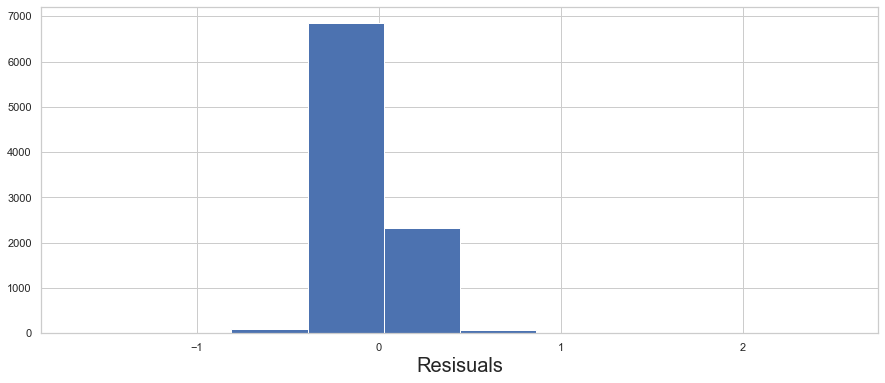

In [28]:
train_resid.hist(figsize=(15,6))
plt.xlabel("Resisuals", fontsize=20);

- The Histogram above shows the distribution of our Residual Errors

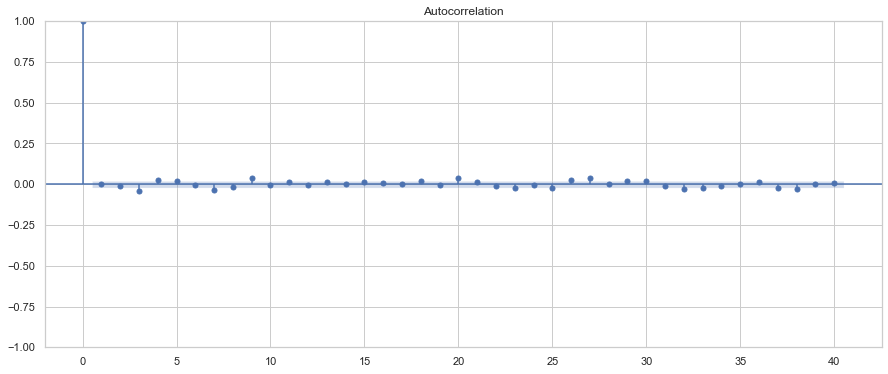

In [155]:
fig,ax=plt.subplots(figsize=(15,6))
plot_acf(train_resid,ax=ax);

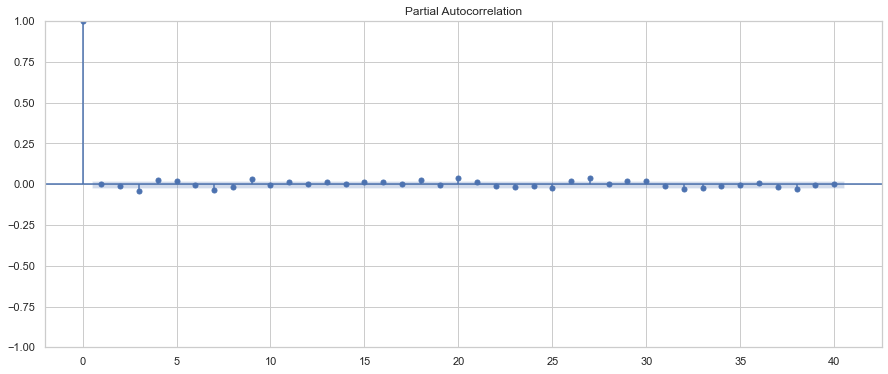

In [156]:
fig,ax=plt.subplots(figsize=(15,6))
fig1=plot_pacf(train_resid,ax=ax)

##### Next, we would Implement Walk Forward Validation to Forecast predictions on our test set

In [30]:
train_pred_wfv=pd.Series()
history=train.copy()
for i in range(len(test)):
    model1=AutoReg(history, lags=best_p).fit()
    next_pred=model1.forecast()
    train_pred_wfv=train_pred_wfv.append(next_pred)
    history=history.append(test[next_pred.index])
    
    pass
train_pred_wfv.name="Prediction"
train_pred_wfv.index.name="Day"
train_pred_wfv.head()

Day
2019-10-07    2.355423
2019-10-08    2.307559
2019-10-09    2.291857
2019-10-10    2.238788
2019-10-11    2.222002
Freq: D, Name: Prediction, dtype: float64

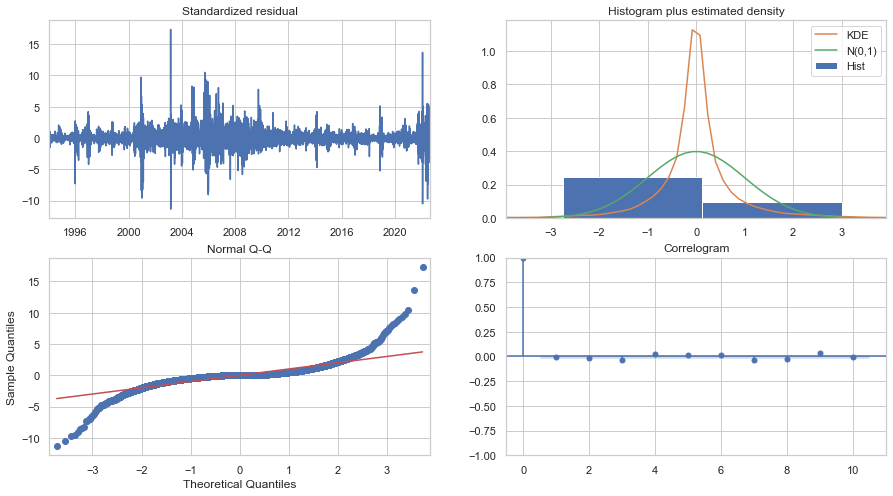

In [31]:
model1.plot_diagnostics(figsize=(15,8))
plt.show()

##### Creating a dataframe of the actual prices and our predicted prices

In [32]:
df_pred_test=pd.DataFrame(
    {"Actual" :test, "Predicted" : train_pred_wfv}, index=test.index
)
df_pred_test.tail(10)

Actual  Predicted
Day                          
2022-08-07   8.064   8.056693
2022-08-08   7.589   8.056696
2022-08-09   7.833   7.603746
2022-08-10   8.202   7.814988
2022-08-11   8.874   8.177896
2022-08-12   8.768   8.836057
2022-08-13   8.768   8.764325
2022-08-14   8.768   8.759662
2022-08-15   8.728   8.759667
2022-08-16   9.329   8.721486

##### Visualising our Actual and Predicted values using Plotly

In [33]:
import plotly.express as px
fig=px.line(df_pred_test, labels={"value":"Natural Gas Price"})
fig.update_layout(
    title="Time Series of Natural Gas Prices - Actual vs Predicted",
    xaxis_title="Date",
    yaxis_title="Price"
)
fig.show()

As seen in the plot above, our predicted values nearly coincide with the actual values, meaning our model did well in predictions.
##### Next, lets Evaluate our model using the below performance metrics

In [34]:
mse=mean_squared_error(test,train_pred_wfv)
print("MSE: "+str(mse))
mae=mean_absolute_error(test,train_pred_wfv)
print("MAE: "+str(mae))
rmse=math.sqrt(mean_squared_error(test,train_pred_wfv))
print("RMSE: "+str(rmse))
mape=np.mean(np.abs(train_pred_wfv-test)/np.abs(test))
print("MAPE: "+str(mape))

MSE: 0.03264106695936819
MAE: 0.08716875697275103
RMSE: 0.1806683894857321
MAPE: 0.022079923970788857


### With a Mean absolute Percentage Error(MAPE) of about 0.022, we can say our model performed great, having an estimated accuracy of about 97.8%

# AUTO REGRESSIVE INTEGRATED MOVING AVERAGE(ARIMA)

#### In order to use ARIMA as our model, it is important that our data is stationary, so there won't be bias in our forecasting. A stationary data is one that has a independent of time. in order words, it has a constant mean and variance over time, and our model need not come up with two many features as a result of a constantly changing trend. Hence, the first step is to test for the stationarity of our data. There are two most common tests for stationarity, viz;
**ADF TEST** : Using this test, one can only reject the null hypothesis(infer that the data is stationary) if the p-value is less than the significance value of 0.05, and if the test statistics is less than that of the critical values.

**KPSS TEST** : This test is the opposite of the ADF test even if they haave the same aim of testing for stationarity.
Using this test, one can only reject the null hypothesis(infer that the data is stationary) if the p-value is greater than the significance value of 0.05, and if the test statistics is greater than that of the critical values.

##### We would start by creating the Tests' Functions

In [35]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest=kpss(timeseries, regression="ct")
    kpss_out=pd.Series(kpsstest[0:3], index=["Test Statistics","p-value", "Lags Used"])
    for key,value in kpsstest[3].items():
        kpss_out["Critical Value (%s)" % key]=value
    print(kpss_out)

In [36]:
def adf_test(timeseries):
    print("Results of ADF test")
    result=adfuller(timeseries)
    print("ADF Statistics : %f" % result[0])
    print("p-value: %f" % result[1])
    print("Critical Values:")
    for key,value in result[4].items():
        print('\t%s: %.3f' % (key,value))

In [37]:
adf_test(df1["gas_price"])

Results of ADF test
ADF Statistics : -2.832804
p-value: 0.053739
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


With a p-value greater than 0.05, one can infer that the data is non stationary using the ADF TEST.
lets look at the results of the KPSS TEST

In [38]:
kpss_test(df1["gas_price"])

Results of KPSS Test:
Test Statistics           2.174697
p-value                   0.010000
Lags Used                60.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


With a p-value Less than 0.05, one can infer that the data is non stationary using the KPSS TEST

##### Now that we know, that our data is Non stationary, making it stationary before model implementation is imperative. one way to make it stationary is DIFFERENCING which would be  done using the "diff()" function

In [88]:
df_stat=df1["gas_price"].diff().dropna()
df_stat.head()

Day
1994-01-14    0.074
1994-01-15    0.000
1994-01-16    0.000
1994-01-17    0.092
1994-01-18   -0.042
Freq: D, Name: gas_price, dtype: float64

##### Now, lets test for the stationarity.

In [89]:
adf_test(df_stat)

Results of ADF test
ADF Statistics : -17.090691
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [90]:
kpss_test(df_stat)

Results of KPSS Test:
Test Statistics           0.056798
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


#### We can conclude from both tests above, that a first order differing(d=1) would make our data stationaty.

Lets take a look at the ACF AND PACF plots neccesary for determing our model order

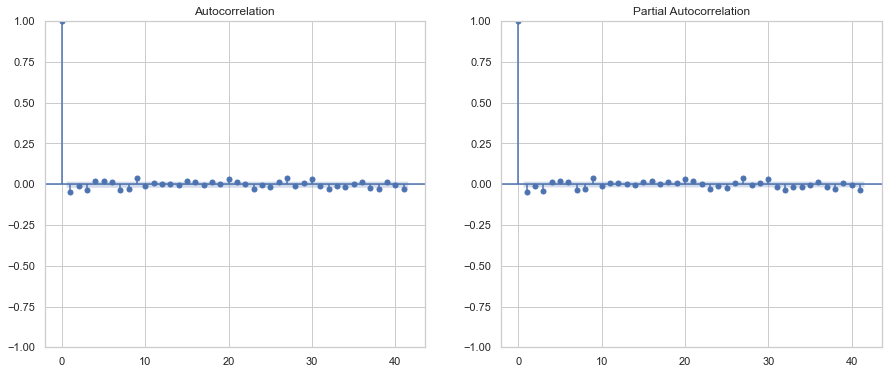

In [91]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
fig=plot_acf(df_stat,ax=ax[0])
fig=plot_pacf(df_stat,ax=ax[1])

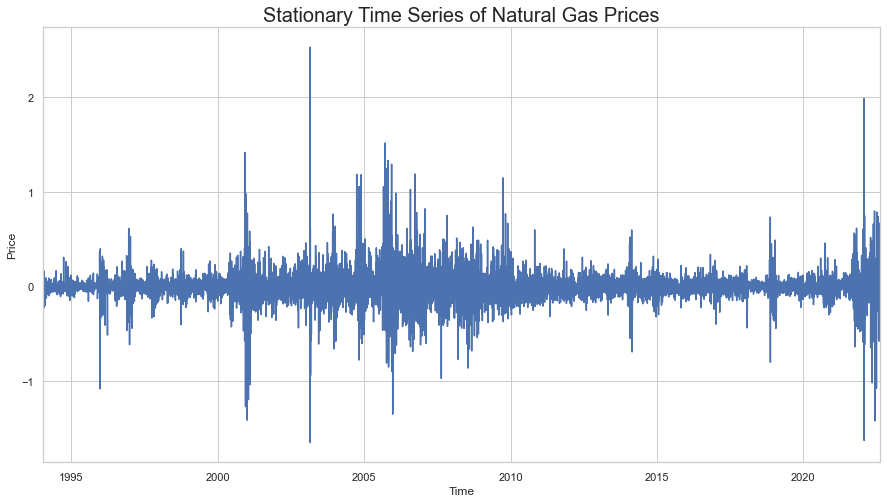

In [125]:
df_stat.plot(kind="line")
plt.title("Stationary Time Series of Natural Gas Prices", fontsize=20)
plt.xlabel("Time")
plt.ylabel("Price");

The plot above clearly confirmns the stationarity of our data

#### Splitting of our Data

In [104]:
cutoff=int(len(df1["gas_price"])*0.95)
train=df1["gas_price"].iloc[:cutoff]
test=df1["gas_price"].iloc[cutoff:]
print("Shape of Training Data :", train.shape)
print("Shape of Test Data :", test.shape)

Shape of Training Data : (9920,)
Shape of Test Data : (523,)


#### Lets Tune our parameters in order to get the best order(one with the least MAE) to be used for final model

In [101]:
p_params=range(0,3,1)
q_params=range(0,3,1)

In [105]:
mae_grid={}
for p in p_params:
    mae_grid[p]=[]
    for q in q_params:
        order=(p,1,q)
        start_time=time.time()
        model2=ARIMA(train,order=order).fit()
        end_time=round(time.time()-start_time,2)
        print(f" Trained Model {order} in {end_time} seconds")
        pred1=model2.predict()
        mae=mean_absolute_error(train,pred1)
        mae_grid[p].append(mae)
        
print()
print(mae_grid)

 Trained Model (0, 1, 0) in 0.7 seconds
 Trained Model (0, 1, 1) in 2.43 seconds
 Trained Model (0, 1, 2) in 2.33 seconds
 Trained Model (1, 1, 0) in 0.97 seconds
 Trained Model (1, 1, 1) in 5.45 seconds
 Trained Model (1, 1, 2) in 11.5 seconds
 Trained Model (2, 1, 0) in 2.5 seconds
 Trained Model (2, 1, 1) in 6.48 seconds
 Trained Model (2, 1, 2) in 9.03 seconds

{0: [0.0702741935483871, 0.07052377252743397, 0.07070655773266617], 1: [0.07051067734879456, 0.0709548046914979, 0.07100527775453216], 2: [0.07066401169978126, 0.07101130751505279, 0.07093436879923386]}


In [106]:
mae_df=pd.DataFrame(mae_grid)
mae_df.round(4)

0       1       2
0  0.0703  0.0705  0.0707
1  0.0705  0.0710  0.0710
2  0.0707  0.0710  0.0709

In [107]:
mae_df.min()

0    0.070274
1    0.070511
2    0.070664
dtype: float64

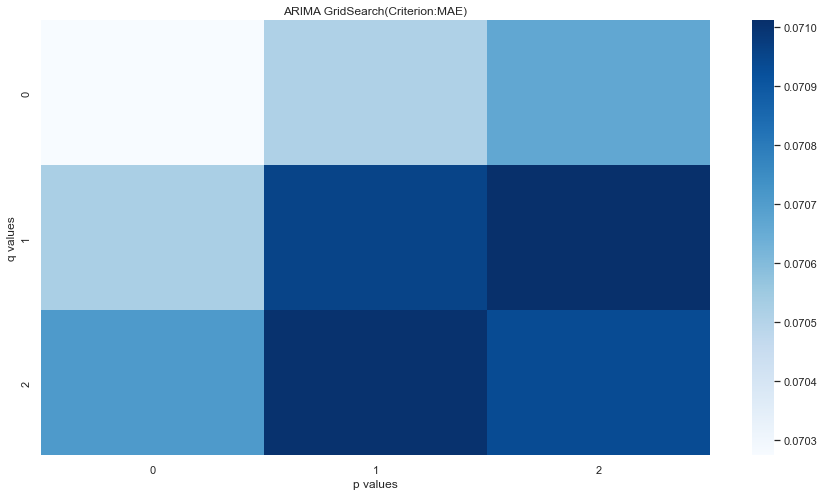

In [108]:
sns.heatmap(mae_df,cmap="Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARIMA GridSearch(Criterion:MAE)");

#### From the above analysis, the order of our best Model in terms of MAE and computational time is 1,1,1. I chose this in favour of 0,1,0 (Random Walk) as i intend on bullding a general model that can be used for future predictions of more than one day , rather than a Naive Forecast.

##### Lets Build our model now, using the best order we've determined.

In [129]:
best=ARIMA(train,order=(1,1,1)).fit()

In [133]:
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              gas_price   No. Observations:                 9920
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5492.810
Date:                Sat, 27 Aug 2022   AIC                         -10979.619
Time:                        19:36:29   BIC                         -10958.013
Sample:                    01-13-1994   HQIC                        -10972.303
                         - 03-11-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6060      0.089      6.819      0.000       0.432       0.780
ma.L1         -0.6305      0.086     -7.305      0.000      -0.800      -0.461
sigma2         0.0193   6.74e-05    287.178      0.000       0.019       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            405384.02
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

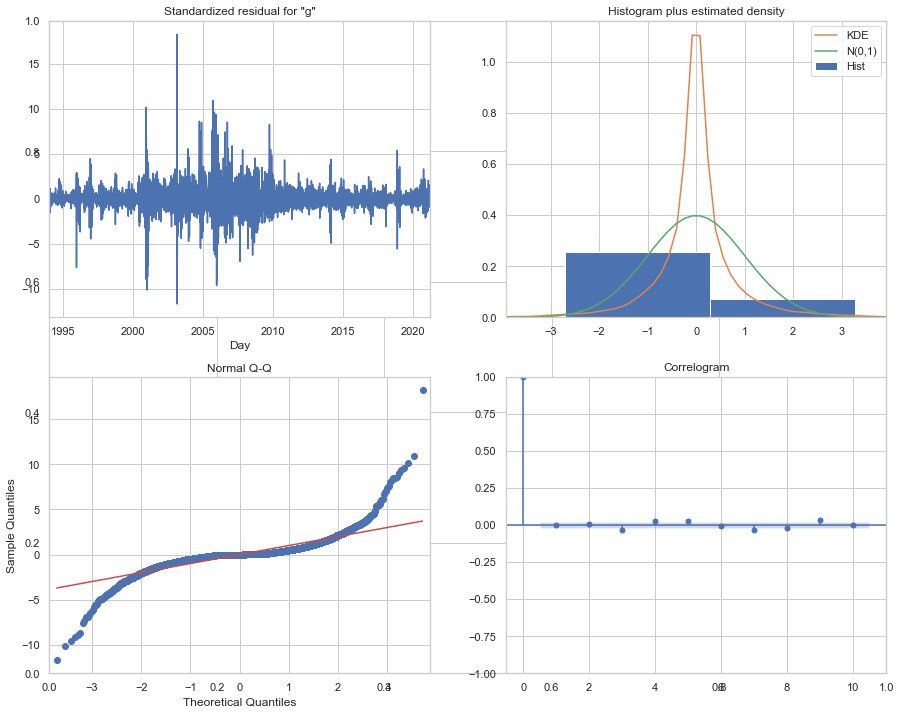

In [130]:
fig,ax=plt.subplots(figsize=(15,12))
best.plot_diagnostics(fig=fig);

The plot diagnostics reveal the following information :
- Top left : The Residual errors seems to flunctuate around a mean of zero
- Top Right : The density plot shows normal distribution with mean zero
- Bottom Left : All the dots should fall perfectly in line with the red line. Any nsignificant deviations would imply the distribution is skewed, hence ours is skewed.
- Bottom Right : The correlogram(ACF plot) shows that the Residual errors are not correlated.

#### Lets see how our model is performing on our train set

In [131]:
fitted_values=best.fittedvalues

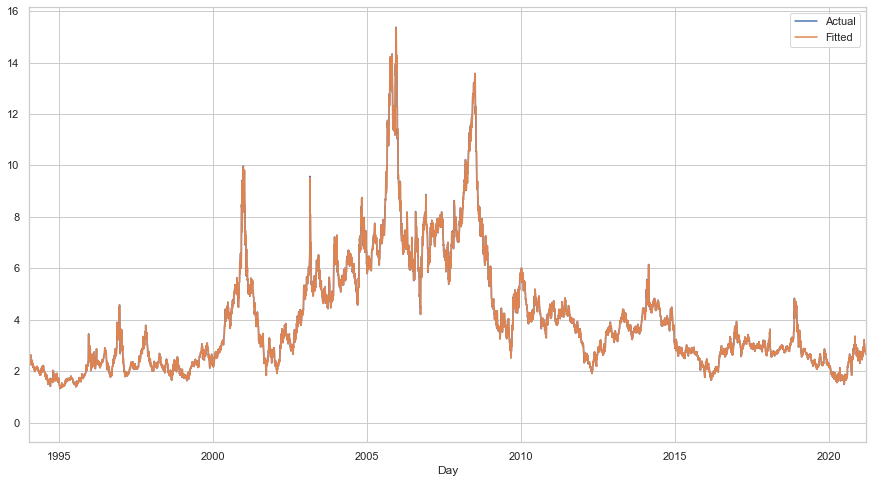

In [134]:
fig,ax=plt.subplots(figsize=(15,8))
train.plot(kind="line",ax=ax, label="Actual")
fitted_values.plot(kind="line",ax=ax, label="Fitted")
plt.legend();

In [141]:
mse=mean_squared_error(train,fitted_values)
print("MSE: "+str(mse))
mae=mean_absolute_error(train,fitted_values)
print("MAE: "+str(mae))
rmse=math.sqrt(mean_squared_error(train,fitted_values))
print("RMSE: "+str(rmse))
mape=mean_absolute_percentage_error(train,fitted_values)
print("mape: "+str(mape))

MSE: 0.01982657697908536
MAE: 0.0709548046914979
RMSE: 0.14080687830885735
mape: 0.017495444058313953


- With an MAPE of just about 2%(98% accuracy), and the almost coincided plot of our predictions on the actual data, we have a good Model.

##### Next, we would Implement Walk Forward Validation to Forecast predictions on our test set

In [142]:
start_time=time.time()
train_pred_wfv=pd.Series()
history=train.copy()
for i in range(len(test)):
    model1=ARIMA(history, order=(1,1,1)).fit()
    next_pred=model1.forecast()
    train_pred_wfv=train_pred_wfv.append(next_pred)
    history=history.append(test[next_pred.index])
    
end_time=round(time.time()-start_time,2)
print(f" Trained Model in {end_time} seconds")
train_pred_wfv.name="Prediction"
train_pred_wfv.index.name="Day"
train_pred_wfv.head()

 Trained Model in 2333.72 seconds


Day
2021-03-12    2.668504
2021-03-13    2.601988
2021-03-14    2.601250
2021-03-15    2.600789
2021-03-16    2.487340
Freq: D, Name: Prediction, dtype: float64

#### Save Model

In [162]:
import pickle
with open("ARIMA-Model(Gas)", "wb") as f :
    pickle.dump(model, f)
print("Model Saved")

Model Saved


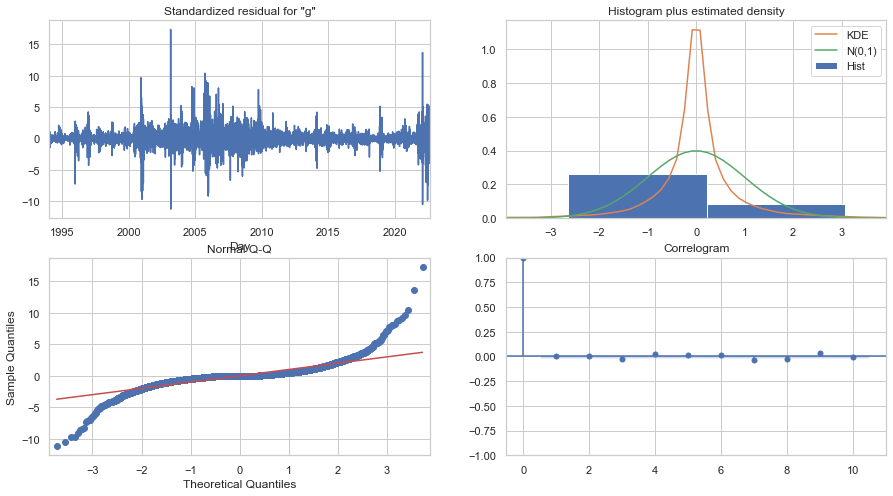

In [143]:
model1.plot_diagnostics(figsize=(15,8))
plt.show()

##### Creating a dataframe of the actual prices and our predicted prices

In [161]:
df_pred_test=pd.DataFrame(
    {"Actual" :test, "Forecast" : round(train_pred_wfv,3)}, index=test.index
)
df_pred_test.tail(10)

Actual  Forecast
Day                         
2022-08-07   8.064     8.065
2022-08-08   7.589     8.064
2022-08-09   7.833     7.611
2022-08-10   8.202     7.831
2022-08-11   8.874     8.184
2022-08-12   8.768     8.836
2022-08-13   8.768     8.756
2022-08-14   8.768     8.763
2022-08-15   8.728     8.766
2022-08-16   9.329     8.729

#### Visualising our Newly Created Dataframe

In [146]:
import plotly.express as px
fig=px.line(df_pred_test, labels={"value":"Natural Gas Price"})
fig.update_layout(
    title="Time Series of Natural Gas Prices - Actual vs Forecast",
    xaxis_title="Date",
    yaxis_title="Price"
)
fig.show()

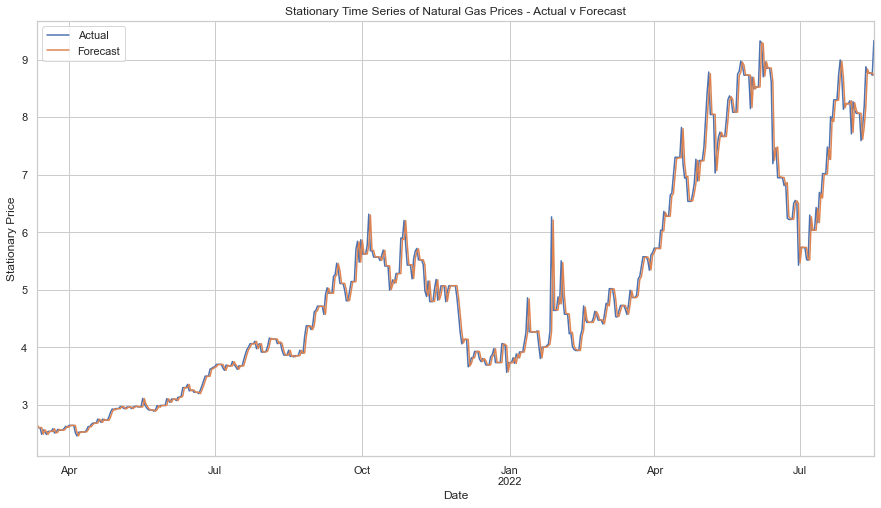

In [147]:
df_pred_test.plot(kind="line")
plt.title("Stationary Time Series of Natural Gas Prices - Actual v Forecast")
plt.xlabel("Date")
plt.ylabel("Stationary Price")
plt.legend(loc="upper left");

As seen in the plot above, our predicted values nearly coincide with the actual values, meaning our model did well in Forecasting.
##### Next, lets Evaluate our model using the below performance metrics

In [144]:
mse=mean_squared_error(test,train_pred_wfv)
print("MSE: "+str(mse))
mae=mean_absolute_error(test,train_pred_wfv)
print("MAE: "+str(mae))
rmse=math.sqrt(mean_squared_error(test,train_pred_wfv))
print("RMSE: "+str(rmse))
mape=mean_absolute_percentage_error(test,train_pred_wfv)
print("MAPE: "+str(mape))

MSE: 0.05980083320835713
MAE: 0.12806117802352418
RMSE: 0.24454208882799117
MAPE: 0.023459351099502004


### With a Mean absolute Percentage Error(MAPE) of about 0.023, we can say our model performed great, having an estimated accuracy of about 97.7%